<details>
   <summary>Metadata</summary>
    title: "E-TRAINEE Tutorial - Multi-dimensional arrays: xarray"<br>
    description: "This is a tutorial within the first theme of Module 1 of the E-TRAINEE course."<br>
    lastUpdate: 2025-03-05<br>
    authors: Andreas Mayr<br>
</details>

# Multi-dimensional arrays: xarray

This short tutorial provides an introduction to raster handling with Python using the [xarray](https://docs.xarray.dev/en/stable/) package ([Hoyer and Hamman 2017](https://doi.org/10.5334/jors.148)) for multi-dimensional data. Xarray's data structures (`DataArray` and `Dataset`, see [here](https://docs.xarray.dev/en/stable/user-guide/terminology.html)) complement NumPy-like arrays by labels in the form of dimensions, coordinates and attributes, thereby encoding information about how the array values are absolutely related to space, time etc. The labels can also be used to access and analyse the array values. These properties and functionality are very useful if you work with time series of remote sensing images or other raster data. Many of the visualizations in this tutorial could be improved with a few lines of code (e.g. to add axes labels and plot titles) or by using specialized plotting packages, but here we try to keep the code simple.

<center>
<img src="toolbox_media/xarray_dataset.png" title="Xarray Dataset" width="700">

*Xarray Dataset structure. Spectral bands can be treated as data variables, time as a dimension in addition to the spatial dimensions (modified from the [xarray User Guide](https://docs.xarray.dev/en/stable/user-guide/data-structures.html#dataset)).*
</center>

**Data**

As a sample dataset, we use a a single GeoTiff file with six bands; this image is part of an image time series in the *module1/module1_data/T1/S2* folder of the [ETRAINEE course datasets](https://doi.org/10.5281/zenodo.10003574) (we'll use the time series in one of the next tutorials). The imagery was acquired by one of the two Sentinel-2 satellites and covers a relatively small area around the village of [Obergurgl](https://opentopomap.org/#marker=14/46.87002/11.02611), located in the Central Alps of Tyrol (Austria). This imagery has been queried from the [Google Earth Engine](https://earthengine.google.com/) (GEE), then cloud-masked and exported from GEE.

## Getting started with xarray's data structures and basic tools

### Loading and handling single images

In this tutorial, we start with importing and exploring a single GeoTiff file with six bands. A good way to do this is using [rioxarray](https://corteva.github.io/rioxarray/stable/index.html), a geospatial xarray extension powered by rasterio. Rioxarray extends xarray by improved support for geospatial metadata, as rasterio does for numpy arrays.

In [1]:
import rioxarray
import xarray
from pathlib import Path

In [2]:
# Open a GeoTiff from a local directory using the rio accessor
data_dir = Path('F:/data/etrainee_m1/module1/module1_data/T1/s2')   # Define the path to the s2 directory with the Sentinel-2 image subsets on your local system
in_file = data_dir / '20180726T102019_20180726T102150_T32TPS.tif'   # Specify the path and the filename of an image
xds = rioxarray.open_rasterio(in_file, masked=True)     # Read the mask (NoData in the GeoTiff) and set values to NaN (for proper interpretation by xarray)

Print some information about the xarray.DataArray called 'xds':

In [3]:
xds

<xarray.DataArray (band: 6, y: 201, x: 251)> Size: 1MB
[302706 values with dtype=float32]
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 2kB 6.516e+05 6.516e+05 ... 6.566e+05 6.566e+05
  * y            (y) float64 2kB 5.194e+06 5.194e+06 ... 5.19e+06 5.19e+06
    spatial_ref  int64 8B 0
Attributes:
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    AREA_OR_POINT:           Area
    scale_factor:            1.0
    add_offset:              0.0

Or more specifically:

In [4]:
print(xds.shape)
print(xds.dims)
print(xds.coords)

(6, 201, 251)
('band', 'y', 'x')
Coordinates:
  * band         (band) int64 48B 1 2 3 4 5 6
  * x            (x) float64 2kB 6.516e+05 6.516e+05 ... 6.566e+05 6.566e+05
  * y            (y) float64 2kB 5.194e+06 5.194e+06 ... 5.19e+06 5.19e+06
    spatial_ref  int64 8B 0


... and some descriptive statistics for one band (using xarray's built-in methods, but numpy could be used as well):

In [5]:
# Extract a band to a new DataArray (for conveniance)
band_1 =xds.sel(band=1)
print('min: ', band_1.min().values)     # Print only the value(s) of the array; its only one value for one band and one time stamp 
print('max: ', band_1.max().values)
print('mean: ', band_1.mean().values)
print('std: ', band_1.std().values)

min:  138.0
max:  6651.0
mean:  666.3885498046875
std:  358.31658935546875


We can use the extended capabilities of rioxarray to query more metadata, such as coordinate reference system (CRS), bounding coordinates, dimensions, spatial resolution, or defined NoData value:

In [6]:
print(xds.rio.crs)
print(xds.rio.bounds())
print(xds.rio.width)
print(xds.rio.height)
print(xds.rio.resolution())
print(xds.rio.nodata)

EPSG:32632
(651580.0, 5189740.0, 656600.0, 5193760.0)
251
201
(20.0, -20.0)
nan


### Plotting DataArrays

Creating a new DataArray with only one selected band is straightforward and plotting this is easy as well (matplotlib must be installed in the active conda environment). Note the white NoData areas due to cloud masking:

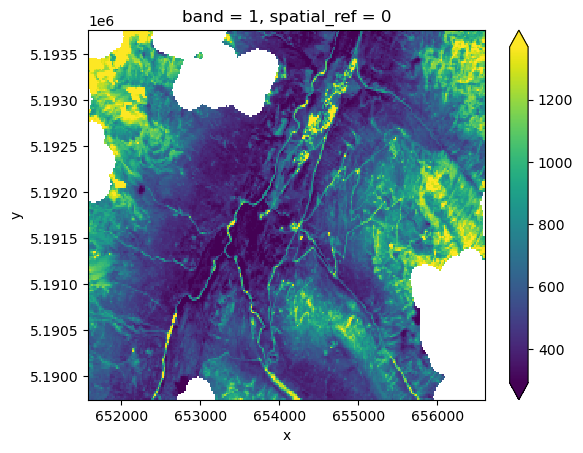

In [7]:
band_1 = xds.sel(band=1)            # Select a band by its label (or by its index with '.isel()'), as already shown above
band_1.plot.imshow(robust=True)     # The 'robust' option stretches the colormap range to 2nd and 98th percentiles.

Now let's create a histogram for this band. We use [xarray.plot.hist()](https://docs.xarray.dev/en/latest/generated/xarray.plot.hist.html), for more advanced options there are the [xhistogram](https://xhistogram.readthedocs.io/en/latest/index.html) and the [boost-histogram](https://boost-histogram.readthedocs.io/en/latest/notebooks/xarray.html) packages. You might try different estimators to determine the optimum number of bins (see [here](https://numpy.org/doc/stable/reference/generated/numpy.histogram_bin_edges.html#numpy.histogram_bin_edges); default would be 10 bins; 'auto' takes the maximum of the Sturges and Freedman Diaconis estimators).

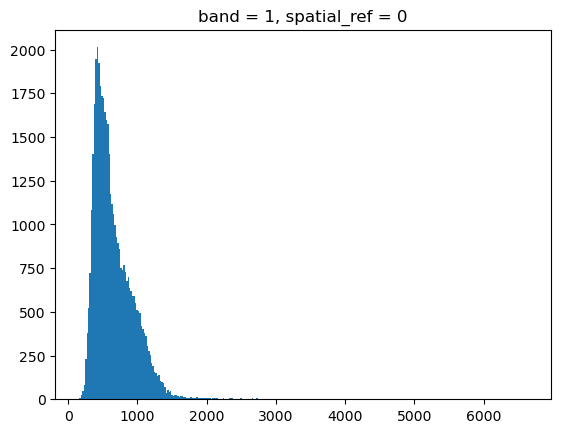

In [8]:
xds.sel(band=1).plot.hist(bins='auto'); # The semicolon tells Jupyter Notebook not to display the output of that line of code (i.e. the bin values; but it will show the histogram).

Similarly, we can plot 3-band combinations as true-color or false-color (color-infrared, CIR) image by selecting the bands to plot as RGB:

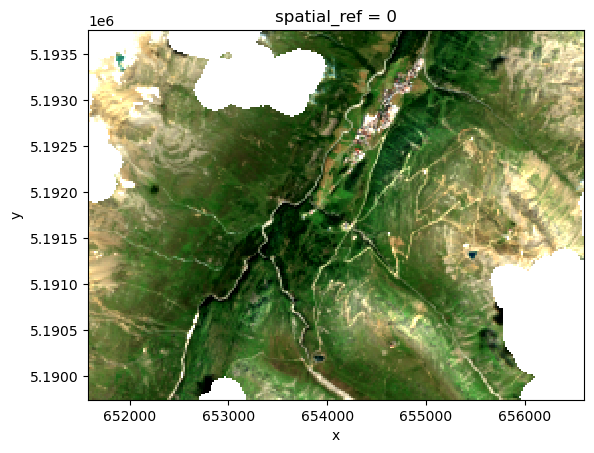

In [9]:
xds.sel(band=[3, 2, 1]).plot.imshow(robust=True)

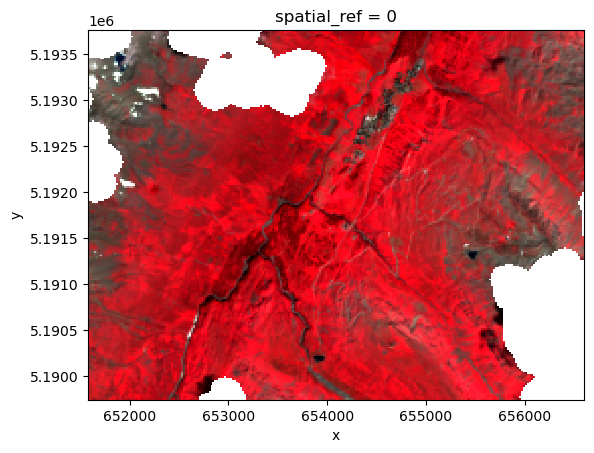

In [10]:
xds.sel(band=[4, 3, 2]).plot.imshow(robust=True)

Instead of using ```robust=True``` we could also constrain the color stretch to the respective quantiles using the ```vmin``` and ```vmax``` keyword arguments. Try also other quantiles or explicit values and see how this affects the image display.

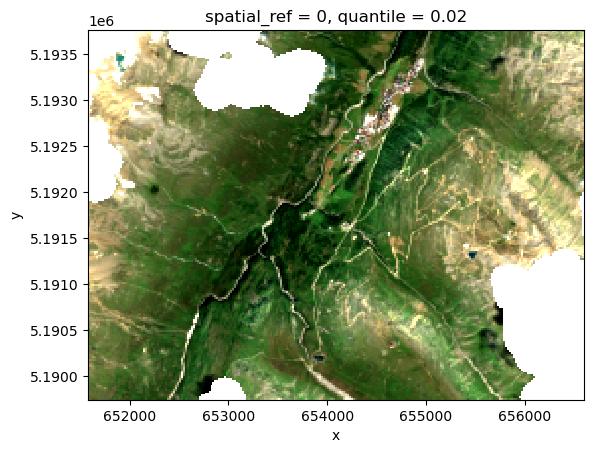

In [11]:
xds.sel(band=[3, 2, 1]).plot.imshow(
    vmin=xds.sel(band=[3, 2, 1]).quantile(0.02),
    vmax=xds.sel(band=[3, 2, 1]).quantile(0.98))

Now you know how to work with `xarray` on a single multispectral image and you are ready to expand this by the time dimension. Several tutorials of E-TRAINEE Module 1 use `xarray` to handle satellite image time series.